# CUSTOMER SEGMENTATION Using K-Means clustering algorithm.
Cluster customers on segments based on their behavior using the K-Means algorithm in Python.

Gather the data

Create Recency Frequency Monetary (RFM) table

Manage skewness and scale each variable

Explore the data

Cluster the data

Interpret the result

In [2]:
# Import The Libraries
#! pip install xlrd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Import The Dataset
df = pd.read_excel('Online Retail.xlsx')
df = df[df['CustomerID'].notna()]

In [4]:
# Sample the dataset
df_fix = df.sample(10000, random_state = 42)

In [5]:
df_fix

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
47912,540456,48185,DOORMAT FAIRY CAKE,2,2011-01-07 12:14:00,7.95,13534.0,United Kingdom
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,2011-09-15 13:51:00,3.95,14894.0,United Kingdom
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,2011-08-03 10:10:00,0.85,12921.0,United Kingdom
325368,565438,22382,LUNCH BAG SPACEBOY DESIGN,4,2011-09-04 13:56:00,1.65,17229.0,United Kingdom
331450,566016,21212,PACK OF 72 RETROSPOT CAKE CASES,24,2011-09-08 12:20:00,0.55,15144.0,United Kingdom
...,...,...,...,...,...,...,...,...
123,536381,22083,PAPER CHAIN KIT RETROSPOT,1,2010-12-01 09:41:00,2.95,15311.0,United Kingdom
449041,C575082,21843,RED RETROSPOT CAKE STAND,-4,2011-11-08 13:30:00,10.95,12613.0,Germany
425967,573340,21733,RED HANGING HEART T-LIGHT HOLDER,2,2011-10-30 11:55:00,2.95,14159.0,United Kingdom
70029,541997,22919,HERB MARKER MINT,5,2011-01-25 10:38:00,0.65,18077.0,United Kingdom


In [6]:
# Convert to show date only
from datetime import datetime
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date

In [7]:
# Create TotalSum colummn
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]

In [8]:
# Create date variable that records recency
import datetime
snapshot_date = max(df_fix.InvoiceDate) + datetime.timedelta(days=1)

In [9]:
# Aggregate data by each customer
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

In [10]:
# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [12]:
customers

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,40,5,133.20
12348.0,249,2,120.88
12349.0,19,2,312.75
12352.0,73,5,80.85
12354.0,233,2,33.30
...,...,...,...
18265.0,73,2,39.60
18272.0,3,11,206.17
18274.0,18,2,-4.65


We can transform the RFM table with this code-

In [13]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2685,7.832068,0.591193,3.408514
2686,1.269495,1.435599,5.907565
2687,4.288385,0.591193,-1.669108
2688,1.665555,1.615329,4.273206
2689,6.340700,1.017445,4.087250


In [14]:
# Import library
from sklearn.preprocessing import StandardScaler

In [15]:
# Initialize the Object
scaler = StandardScaler()

In [16]:
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

In [17]:
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0. -0.  0.]
[1. 1. 1.]


In [18]:
customers_normalized

array([[-0.49379352,  1.01242554,  1.01750301],
       [ 1.23294891, -0.01741182,  0.92511465],
       [-0.99491738, -0.01741182,  1.97269038],
       ...,
       [-1.02771206, -0.01741182, -2.83326622],
       [-1.77905327,  1.94900123,  0.54365651],
       [-0.43980189,  0.80102263,  0.43798027]])

# Modelling
To make our clustering reach its maximum performance, we have to determine which hyperparameter fits to the data. 
To determine which hyperparameter is the best for our model and data, we can use the elbow method to decide.

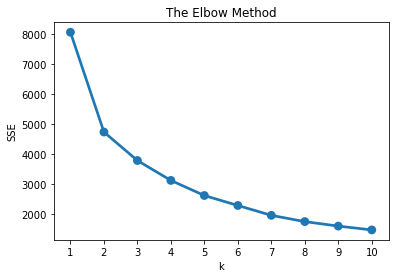

In [20]:
import seaborn as sns
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Based on our observation, the k-value of 3 is the best hyperparameter for our model because the next k-value tend to have a linear trend. Therefore, our best model for the data is K-Means with the number of clusters is 3.

In [27]:
# fit the model 
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2690,)

# Interpret The Segment
Summarize the RFM table based on clusters and calculate the mean of each variable.

In [22]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         47.21      1.62         21.58   808
1        226.64      1.64         28.66   960
2         46.31      7.72        166.06   922

In [23]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

In [24]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12347.0,2,Recency,-0.493794
1,12348.0,1,Recency,1.232949
2,12349.0,2,Recency,-0.994917
3,12352.0,2,Recency,-0.012582
4,12354.0,1,Recency,1.155005


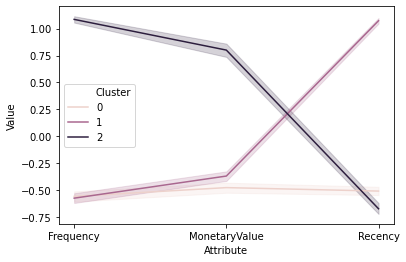

In [25]:
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

By using this plot, we know how each segment differs. 

We infer that cluster 0 is frequent, they spend more, and they bought the product recently. Therefore, it could be the cluster of a loyal customer.

Then, the cluster 1 is less frequent, less to spend, but they bought the product recently. Therefore, it could be the cluster of new customer.

Finally, the cluster 2 is less frequent, less to spend, and they buy the product at the old time. Therefore, it could be the cluster of churned customers.

# Conclusion

Customer segmentation is really necessary for knowing what characteristics that exist on each customer.